In [1]:
import torch
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

#use gpu number 3 
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

#file_id=6448
file_id=23114

base_path="/home/eloi/projects/project_mfm_eloi/audio_examples/TM_val/"
file_dry=os.path.join(base_path, "dry",str(file_id),"vocals.wav")
file_wet=os.path.join(base_path, "wet",str(file_id),"vocals.wav")

file_dry_fxnorm=os.path.join(base_path,"dry", str(file_id), "vocals_normalized.wav")
file_wet_fxnorm=os.path.join(base_path, "wet",str(file_id), "vocals_normalized.wav")

file_dry_fxnorm_dr=os.path.join(base_path, "dry", str(file_id), "vocals_normalized_dr.wav")
file_wet_fxnorm_dr=os.path.join(base_path, "wet",str(file_id),"vocals_normalized_dr.wav")

import soundfile as sf

print("Loading files:", file_dry, file_wet)
dry, sr = sf.read(file_dry)
print("Loading files:", file_dry, file_wet)
wet, sr = sf.read(file_wet)
print("files loaded")

#file_dry_fxnorm, sr=sf.read(file_dry_fxnorm_dr)
#file_wet_fxnorm, sr=sf.read(file_wet_fxnorm_dr)

dry=torch.from_numpy(dry.T).float().unsqueeze(0)
wet=torch.from_numpy(wet.T).float().unsqueeze(0)

#dry_fxnorm=torch.from_numpy(file_dry_fxnorm.T).float().unsqueeze(0)

dry=dry.mean(dim=1, keepdim=True)

#dry_fxnorm=torch.from_numpy(file_dry_fxnorm.T).float().unsqueeze(0)


start_t=15*sr
segment_length = 524288
wet_segment = wet[...,start_t:start_t + segment_length]


import pyloudnorm as pyln
meter = pyln.Meter(sr)
normaliser = lambda x: pyln.normalize.loudness(
    x, meter.integrated_loudness(x), -18.0
)

print("dry", dry.shape, dry.min(), dry.max())

dry = torch.from_numpy(normaliser(dry.numpy().T).T).float().to(device)
#wet = torch.from_numpy(normaliser(wet.numpy().T).T).float().to(device)
#dry_fxnorm = torch.from_numpy(normaliser(dry_fxnorm.numpy().T).T).float().to(device)


print("dry", dry.shape,dry.min(), dry.max())
dry_segment = dry[...,start_t:start_t + segment_length]


from IPython.display import Audio

Audio(dry_segment[0].cpu().numpy(), rate=sr, normalize=False)
#Audio(wet_segment[0].cpu().numpy(), rate=sr, normalize=True)



Using device: cuda
Loading files: /home/eloi/projects/project_mfm_eloi/audio_examples/TM_val/dry/23114/vocals.wav /home/eloi/projects/project_mfm_eloi/audio_examples/TM_val/wet/23114/vocals.wav
Loading files: /home/eloi/projects/project_mfm_eloi/audio_examples/TM_val/dry/23114/vocals.wav /home/eloi/projects/project_mfm_eloi/audio_examples/TM_val/wet/23114/vocals.wav
files loaded
dry torch.Size([1, 1, 7014686]) tensor(-0.7464) tensor(0.7499)
dry torch.Size([1, 1, 7014686]) tensor(-0.8735, device='cuda:0') tensor(0.8776, device='cuda:0')


In [2]:
from fx_model.distribution_presets.clusters_vocals import get_distributions_Cluster0, get_distributions_Cluster1 

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

from fx_model.fxnormaug_v1 import FxNormAug
randomizer=FxNormAug(sample_rate=sr, mode="train", device=device )


num_examples=512
batch_size=32

inputs_dry = dry_segment.repeat(batch_size, 1, 1).to(device)
inputs_wet = wet_segment.repeat(batch_size, 1, 1).to(device)

outputs_wet = {}

for i in range(0, num_examples, batch_size):
    res=randomizer.forward(inputs_wet)
    if res.shape[1] != 2:
        res= res.repeat(1, 2, 1)
    res_list= res.cpu().unbind(dim=0)
    for j, output in enumerate(res_list):
        outputs_wet[i*batch_size + j] = output



outputs_dry = {}

for i in range(0, num_examples, batch_size):
    res=randomizer.forward(inputs_dry)
    if res.shape[1] != 2:
        res= res.repeat(1, 2, 1)
    res_list= res.cpu().unbind(dim=0)
    for j, output in enumerate(res_list):
        outputs_dry[i*batch_size + j] = output


/home/eloi/myenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/eloi/projects/grafx/src/grafx/processors/core/convolution.py:48: UserWarning: FlashFFTConv is not available. Using native convolution instead.
  warnings.warn(
/home/eloi/projects/grafx/src/grafx/processors/core/fft_filterbank.py:144: UserWarning: At least one bark filterbank has all zero values. The value for `n_bins` (49) may be set too high. Or, the value for `num_frequency_bins` (193) may be set too low.
  warnings.warn(
/home/eloi/myenv/lib/python3.11/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 32 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


x std after compexp tensor(0.0350, device='cuda:0')
x std after compexp tensor(0.0350, device='cuda:0')
x std after compexp tensor(0.0350, device='cuda:0')
x std after compexp tensor(0.0350, device='cuda:0')
x std after compexp tensor(0.0349, device='cuda:0')
x std after compexp tensor(0.0351, device='cuda:0')
x std after compexp tensor(0.0345, device='cuda:0')
x std after compexp tensor(0.0350, device='cuda:0')
x std after compexp tensor(0.0349, device='cuda:0')
x std after compexp tensor(0.0351, device='cuda:0')
x std after compexp tensor(0.0350, device='cuda:0')
x std after compexp tensor(0.0350, device='cuda:0')
x std after compexp tensor(0.0351, device='cuda:0')
x std after compexp tensor(0.0350, device='cuda:0')
x std after compexp tensor(0.0353, device='cuda:0')
x std after compexp tensor(0.0353, device='cuda:0')
x std after compexp tensor(0.0341, device='cuda:0')
x std after compexp tensor(0.0342, device='cuda:0')
x std after compexp tensor(0.0340, device='cuda:0')
x std after 

In [3]:
import torch
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from datasets.tency_mastering_vocals import TencyMastering_Vocals_Test
import omegaconf
normalize_params=omegaconf.OmegaConf.create(
    {
    "normalize_mode": "loudness_dry",
    "loudness_dry": -18.0
    }
)

dataset_val= TencyMastering_Vocals_Test(
  mode= "dry-wet",
  segment_length= 525312,
  fs= 44100,
  stereo= True,
  align= False,
  align_mode= "pickle",
  base_dir= "/data5/eloi/TencyMastering_vocals/validation",
  normalize_params=normalize_params,
  num_examples= -1, #use all examples
  x_as_mono= True,
  RMS_threshold_dB= -40.0,
  seed= 42
)


from fx_model.fxnormaug_v1 import FxNormAug
randomizer=FxNormAug(sample_rate=sr, mode="train", device=device )
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")


import torch
batch_size=32
val_loader = torch.utils.data.DataLoader(dataset=dataset_val, batch_size=batch_size, num_workers=1)


outputs_dry = {}
outputs_wet = {}
for i,( y_wet, x_dry) in enumerate(val_loader):
    #stereo to mono
    #x= x.mean(dim=1, keepdim=True).to(device)
    x_dry= x_dry.mean(dim=1, keepdim=True).to(device)
    res=randomizer.forward(x_dry)
    if res.shape[1] != 2:
        res= res.repeat(1, 2, 1)


    res_list= res.cpu().unbind(dim=0)
    for j, output in enumerate(res_list):
            outputs_dry[i*batch_size + j] = output

    y_wet= y_wet.mean(dim=1, keepdim=True).to(device)
    res_wet=randomizer.forward(y_wet)
    if res_wet.shape[1] != 2:
        res_wet= res_wet.repeat(1, 2, 1)
    res_list_wet= res_wet.cpu().unbind(dim=0)
    for j, output in enumerate(res_list_wet):
            outputs_wet[i*batch_size + j] = output

    i += 1







-1 num_examples


  0%|          | 0/23 [00:00<?, ?it/s]

mode dry-wet


  4%|▍         | 1/23 [00:01<00:35,  1.63s/it]

mode dry-wet


  9%|▊         | 2/23 [00:03<00:35,  1.68s/it]

mode dry-wet


 13%|█▎        | 3/23 [00:05<00:35,  1.76s/it]

mode dry-wet


/home/eloi/myenv/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
 17%|█▋        | 4/23 [00:06<00:31,  1.68s/it]

mode dry-wet


 22%|██▏       | 5/23 [00:08<00:28,  1.60s/it]

mode dry-wet


 26%|██▌       | 6/23 [00:10<00:30,  1.80s/it]

mode dry-wet


 30%|███       | 7/23 [00:11<00:26,  1.64s/it]

mode dry-wet


 35%|███▍      | 8/23 [00:12<00:21,  1.46s/it]

mode dry-wet


 39%|███▉      | 9/23 [00:13<00:18,  1.31s/it]

mode dry-wet


 43%|████▎     | 10/23 [00:15<00:20,  1.59s/it]

mode dry-wet


 48%|████▊     | 11/23 [00:16<00:16,  1.38s/it]

mode dry-wet


 52%|█████▏    | 12/23 [00:17<00:13,  1.24s/it]

mode dry-wet


 57%|█████▋    | 13/23 [00:19<00:12,  1.28s/it]

mode dry-wet


 61%|██████    | 14/23 [00:21<00:13,  1.51s/it]

mode dry-wet


 65%|██████▌   | 15/23 [00:23<00:12,  1.62s/it]

mode dry-wet


 70%|██████▉   | 16/23 [00:24<00:11,  1.67s/it]

mode dry-wet


 74%|███████▍  | 17/23 [00:27<00:11,  1.94s/it]

mode dry-wet


 78%|███████▊  | 18/23 [00:28<00:08,  1.76s/it]

mode dry-wet


 83%|████████▎ | 19/23 [00:30<00:06,  1.71s/it]

mode dry-wet


 87%|████████▋ | 20/23 [00:32<00:05,  1.83s/it]

mode dry-wet


 91%|█████████▏| 21/23 [00:33<00:03,  1.56s/it]

mode dry-wet


 96%|█████████▌| 22/23 [00:34<00:01,  1.52s/it]

mode dry-wet


100%|██████████| 23/23 [00:36<00:00,  1.60s/it]

test_samples 320 num_examples -1



/home/eloi/projects/grafx/src/grafx/processors/core/convolution.py:48: UserWarning: FlashFFTConv is not available. Using native convolution instead.
  warnings.warn(
/home/eloi/projects/grafx/src/grafx/processors/core/fft_filterbank.py:144: UserWarning: At least one bark filterbank has all zero values. The value for `n_bins` (49) may be set too high. Or, the value for `num_frequency_bins` (193) may be set too low.
  warnings.warn(


x std after compexp tensor(0.0347, device='cuda:0')
x std after compexp tensor(0.0353, device='cuda:0')
x std after compexp tensor(0.0350, device='cuda:0')
x std after compexp tensor(0.0356, device='cuda:0')
x std after compexp tensor(0.0348, device='cuda:0')
x std after compexp tensor(0.0355, device='cuda:0')
x std after compexp tensor(0.0351, device='cuda:0')
x std after compexp tensor(0.0358, device='cuda:0')
x std after compexp tensor(0.0349, device='cuda:0')
x std after compexp tensor(0.0357, device='cuda:0')
x std after compexp tensor(0.0354, device='cuda:0')
x std after compexp tensor(0.0358, device='cuda:0')
x std after compexp tensor(0.0354, device='cuda:0')
x std after compexp tensor(0.0359, device='cuda:0')
x std after compexp tensor(0.0346, device='cuda:0')
x std after compexp tensor(0.0355, device='cuda:0')
x std after compexp tensor(0.0348, device='cuda:0')
x std after compexp tensor(0.0357, device='cuda:0')
x std after compexp tensor(0.0346, device='cuda:0')
x std after 

/home/eloi/myenv/lib/python3.11/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4314.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Load the specified checkpoint /data5/eloi/checkpoints/laion_clap/music_audioset_epoch_15_esc_90.14.patched.pt from users.
Load Checkpoint...
logit_scale_a 	 Loaded
logit_scale_t 	 Loaded
audio_branch.spectrogram_extractor.stft.conv_real.weight 	 Loaded
audio_branch.spectrogram_extractor.stft.conv_imag.weight 	 Loaded
audio_branch.logmel_extractor.melW 	 Loaded
audio_branch.bn0.weight 	 Loaded
audio_branch.bn0.bias 	 Loaded
audio_branch.patch_embed.proj.weight 	 Loaded
audio_branch.patch_embed.proj.bias 	 Loaded
audio_branch.patch_embed.norm.weight 	 Loaded
audio_branch.patch_embed.norm.bias 	 Loaded
audio_branch.layers.0.blocks.0.norm1.weight 	 Loaded
audio_branch.layers.0.blocks.0.norm1.bias 	 Loaded
audio_branch.layers.0.blocks.0.attn.relative_position_bias_table 	 Loaded
audio_branch.layers.0.blocks.0.attn.qkv.weight 	 Loaded
audio_branch.layers.0.blocks.0.attn.qkv.bias 	 Loaded
audio_branch.layers.0.blocks.0.attn.proj.weight 	 Loaded
audio_branch.layers.0.blocks.0.attn.proj.bias 	 

/home/eloi/projects/project_mfm_eloi/src/evaluation/dist_metrics.py:490: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y=torch.tensor(y).permute(1,0).unsqueeze(0).to(self.device)
/home/eloi/projects/project_mfm_eloi/src/evaluation/dist_metrics.py:491: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_hat=torch.tensor(y_hat).permute(1,0).unsqueeze(0).to(self.device)


Calculating bandwidth...
y shape: torch.Size([320, 512])
Bandwidth: 0.7386950254440308
distance 1.5904903411865234


/home/eloi/projects/project_mfm_eloi/src/evaluation/dist_metrics.py:101: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


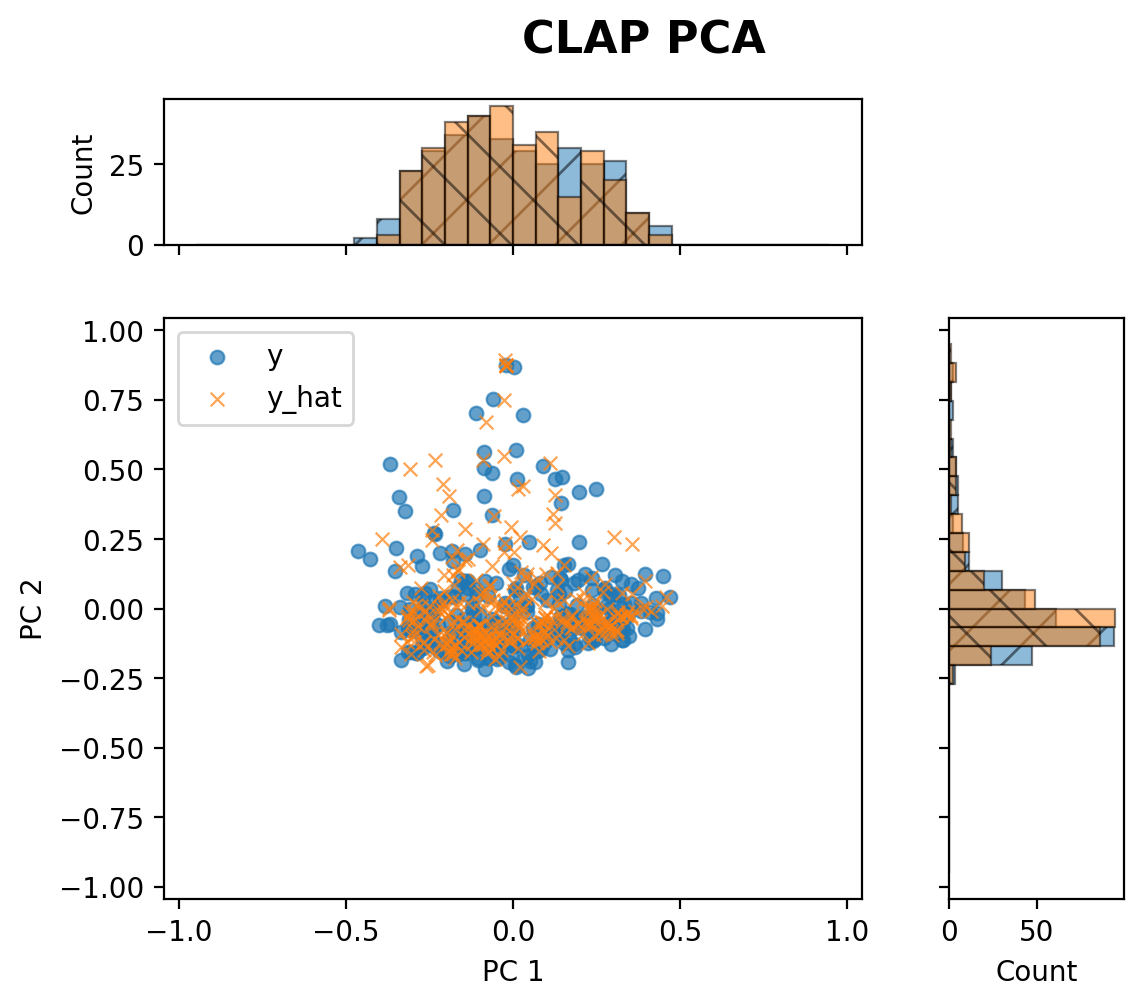

In [7]:
from evaluation.dist_metrics import KADFeatures 
import omegaconf
fx_encoder_args= omegaconf.OmegaConf.create(
    {
        "distance_type": "cosine",
        "ckpt_path": "/home/eloi/projects/project_mfm_eloi/src/utils/feature_extractors/ckpt/fxenc_default.pt",
        "config_file": "/home/eloi/projects/project_mfm_eloi/src/utils/feature_extractors/networks/configs.yaml"
    })

fx_encoder_plusplus_args= omegaconf.OmegaConf.create(
    {
        "distance_type": "cosine",
        "ckpt_path": "/home/eloi/projects/project_mfm_eloi/src/utils/feature_extractors/ckpt/fxenc_plusplus_default.pt",
    })

AFxRep_args= omegaconf.OmegaConf.create(
    {
        "distance_type": "cosine", #distance metric to use for the AFxRep
        "ckpt_path": "/home/eloi/projects/project_mfm_eloi/src/tmp/afx-rep.ckpt"
    }
)

KAD_args = omegaconf.OmegaConf.create(
    {
  "do_PCA_figure": True, #if True, the FAD figure will be compute
  "PCA_fit_mode": "all",
  "kernel": "gaussian" #kernel to use for the KAD metric
    }
)

MERT_args= omegaconf.OmegaConf.create(
    {
        "layer": 8, #use the last layer of the MERT model
        "average": True, #if True, the features will be averaged over time
        "normalize": True
    }
)

CLAP_args = omegaconf.OmegaConf.create(
    {
        "ckpt_path": "/data5/eloi/checkpoints/laion_clap/music_audioset_epoch_15_esc_90.14.patched.pt",
        "distance_type": "cosine",
        "normalize": True, #if True, the features will be normalized
    }
)


#metric = KADFeatures(sample_rate=44100, AFxRep_args=AFxRep_args, fx_encoder_plusplus_args=fx_encoder_plusplus_args, fx_encoder_args=fx_encoder_args, type="fx_encoder_++", KAD_args=KAD_args, MERT_args=MERT_args, CLAP_args=CLAP_args)
metric = KADFeatures(sample_rate=44100, AFxRep_args=AFxRep_args, fx_encoder_plusplus_args=fx_encoder_plusplus_args, fx_encoder_args=fx_encoder_args, type="CLAP", KAD_args=KAD_args, MERT_args=MERT_args, CLAP_args=CLAP_args)

#out_1, out_2= metric.compute(outputs_C0, outputs_C1, None)
out_1, out_2= metric.compute(outputs_dry, outputs_wet, None)

print("distance", out_1)

In [5]:

from IPython.display import Audio

Audio(outputs_dry[316].cpu().clamp(-1,1), rate=sr, normalize=False)
#Audio(x_dry[-2].cpu().clamp(-1,1), rate=sr, normalize=False)


In [6]:
import plotly.express as px
fig=px.line(outputs_dry[318].cpu().numpy()[0, 0:80000], title="Dry output 1")
fig.add_scatter(y=x_dry[-2].cpu().numpy()[0, 0:80000], name="dry original")
fig.add_scatter(y=outputs_wet[318].cpu().numpy()[0, 0:80000], name="Wet output 1")
fig.show()

In [ ]:

import torch
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from datasets.tency_mastering_simulated import TencyMastering_Test
import omegaconf
normalize_params=omegaconf.OmegaConf.create(
    {
    "normalize_mode": "loudness_dry",
    "loudness_dry": -18.0
    }
)

dataset_val_C0= TencyMastering_Test(
  mode= "dry-wet",
  segment_length= 525312,
  fs= 44100,
  stereo= True,
  tracks= ["vocals"],
  clusters= [0],
  path_csv= "/data5/eloi/TencyMastering/PANNs_country_pop/val_split.csv",
  normalize_params=normalize_params,
  num_examples= -1, #use all examples
  x_as_mono= True,
  RMS_threshold_dB= -40.0,
  seed= 42
)

dataset_val_C1= TencyMastering_Test(
  mode= "dry-wet",
  segment_length= 525312,
  fs= 44100,
  stereo= True,
  tracks= ["vocals"],
  clusters= [1],
  path_csv= "/data5/eloi/TencyMastering/PANNs_country_pop/val_split.csv",
  normalize_params=normalize_params,
  num_examples= -1, #use all examples
  x_as_mono= True,
  RMS_threshold_dB= -40.0,
  seed= 42
)

from fx_model.distribution_presets.clusters_vocals import get_distributions_Cluster0, get_distributions_Cluster1 
from fx_model.fx_pipeline import EffectRandomizer
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
distributions_dict_C0=get_distributions_Cluster0(sample_rate=44100)

effect_randomizer_C0=EffectRandomizer(sample_rate=44100, distributions_dict=distributions_dict_C0, device=device)

distributions_dict_C1=get_distributions_Cluster1(sample_rate=44100)
effect_randomizer_C1=EffectRandomizer(sample_rate=44100, distributions_dict=distributions_dict_C1, device=device)


import torch
batch_size=32
val_loader_C0 = torch.utils.data.DataLoader(dataset=dataset_val_C0, batch_size=batch_size, num_workers=1)
val_loader_C1 = torch.utils.data.DataLoader(dataset=dataset_val_C1, batch_size=batch_size, num_workers=1)   


device=torch.device("cuda" if torch.cuda.is_available() else "cpu")



outputs_C0 = {}
for i,( x, cluster) in enumerate(val_loader_C0):
    #stereo to mono
    x= x.mean(dim=1, keepdim=True).to(device)
    #x= x.mean(dim=1, keepdim=True).to(device)

    res=effect_randomizer_C0.forward(x)
    res_list= res.cpu().unbind(dim=0)
    for j, output in enumerate(res_list):
            outputs_C0[i*batch_size + j] = output
    i += 1


outputs_C1 = {}

for i, (x, cluster) in enumerate(val_loader_C1):
    x= x.mean(dim=1, keepdim=True).to(device)
    #x= x.mean(dim=1, keepdim=True).to(device)
    res=effect_randomizer_C1.forward(x)
    res_list= res.cpu().unbind(dim=0)
    for j, output in enumerate(res_list):
            outputs_C1[i*batch_size + j] = output





-1 num_examples
mode dry-wet


4it [00:06,  1.56s/it]/home/eloi/myenv/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/eloi/myenv/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
17it [00:23,  1.40s/it]/home/eloi/myenv/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/home/eloi/myenv/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
19it [00:28,  1.51s/it]


test_samples 234 num_examples -1
-1 num_examples
mode dry-wet


9it [00:10,  1.32s/it]/home/eloi/myenv/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
19it [00:25,  1.35s/it]

test_samples 255 num_examples -1


RuntimeError: indices should be either on cpu or on the same device as the indexed tensor (cpu)

/home/eloi/myenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/eloi/myenv/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Loaded checkpoint from epoch 25
Model loaded successfully on cuda
Computing KAD distance...


/home/eloi/projects/project_mfm_eloi/src/evaluation/dist_metrics.py:493: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y=torch.tensor(y).permute(1,0).unsqueeze(0).to(self.device)
/home/eloi/projects/project_mfm_eloi/src/evaluation/dist_metrics.py:494: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_hat=torch.tensor(y_hat).permute(1,0).unsqueeze(0).to(self.device)


Calculating bandwidth...
y shape: torch.Size([234, 128])
Bandwidth: 0.5773319005966187


/home/eloi/projects/project_mfm_eloi/src/evaluation/dist_metrics.py:101: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


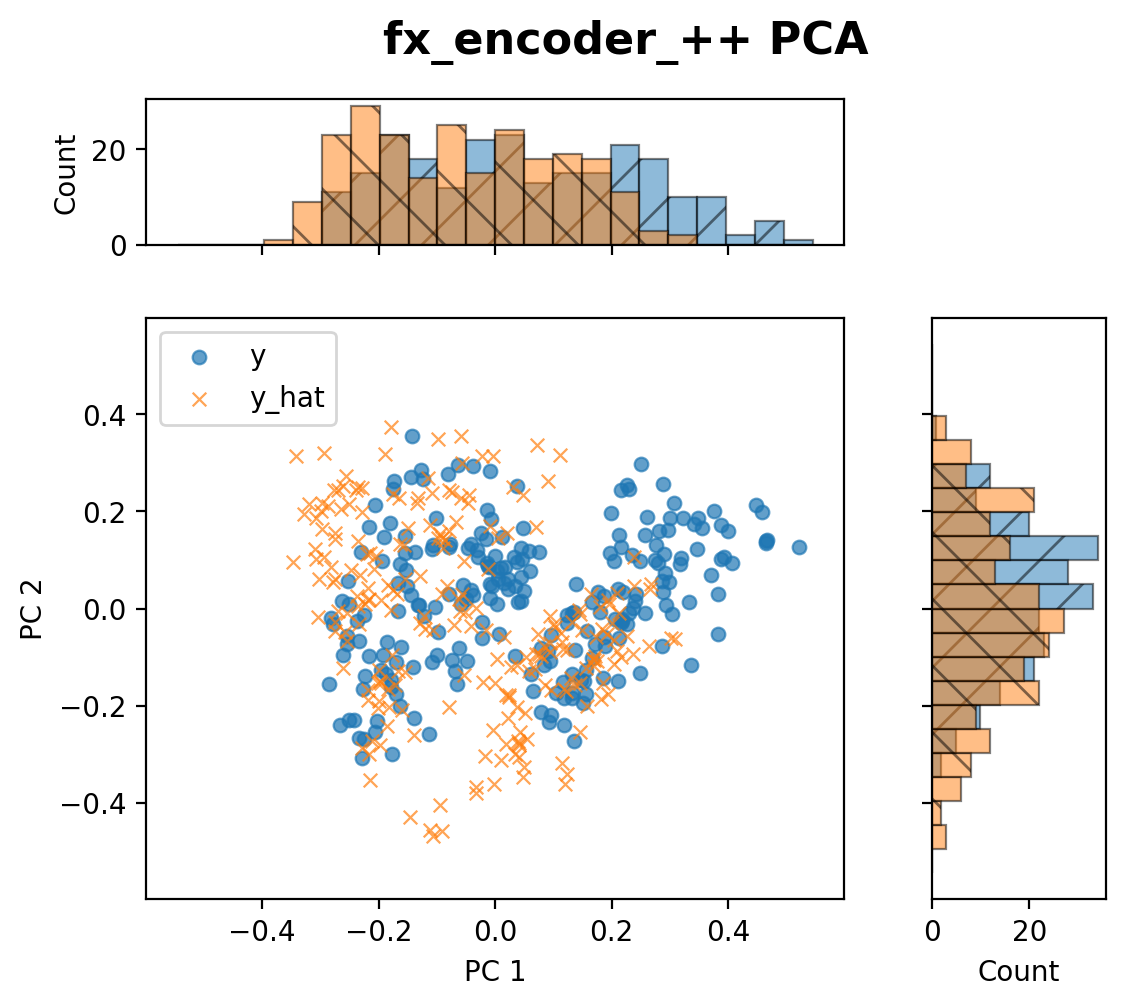

In [ ]:
from evaluation.dist_metrics import KADFeatures 
import omegaconf
fx_encoder_args= omegaconf.OmegaConf.create(
    {
        "distance_type": "cosine",
        "ckpt_path": "/home/eloi/projects/project_mfm_eloi/src/utils/feature_extractors/ckpt/fxenc_default.pt",
        "config_file": "/home/eloi/projects/project_mfm_eloi/src/utils/feature_extractors/networks/configs.yaml"
    })

fx_encoder_plusplus_args= omegaconf.OmegaConf.create(
    {
        "distance_type": "cosine",
        "ckpt_path": "/home/eloi/projects/project_mfm_eloi/src/utils/feature_extractors/ckpt/fxenc_plusplus_default.pt",
    })

AFxRep_args= omegaconf.OmegaConf.create(
    {
        "distance_type": "cosine", #distance metric to use for the AFxRep
        "ckpt_path": "/home/eloi/projects/project_mfm_eloi/src/tmp/afx-rep.ckpt"
    }
)

KAD_args = omegaconf.OmegaConf.create(
    {
  "do_PCA_figure": True, #if True, the FAD figure will be compute
  "PCA_fit_mode": "all",
  "kernel": "gaussian" #kernel to use for the KAD metric
    }
)


metric = KADFeatures(sample_rate=44100, AFxRep_args=AFxRep_args, fx_encoder_plusplus_args=fx_encoder_plusplus_args, fx_encoder_args=fx_encoder_args, type="fx_encoder_++", KAD_args=KAD_args)

out_1, out_2= metric.compute(outputs_C0, outputs_C1, None)

In [4]:
from utils.feature_extractors.fx_encoder_plus_plus import load_model 
import torch
# Load default base model (auto-downloads if needed)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = load_model(
    model_path="/home/eloi/projects/project_mfm_eloi/src/utils/feature_extractors/ckpt/fxenc_plusplus_default.pt",
    device=DEVICE,
)

#lets to mono to stereo
dry_segment= dry_segment.repeat(1, 2,1)  # Repeat the mono signal to create a stereo signal
fx_emb = model.get_fx_embedding(dry_segment)
print(fx_emb.shape) # [1, embed_dim], [1, 128]

Loaded checkpoint from epoch 25
Model loaded successfully on cuda
torch.Size([1, 128])
